In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, classification_report, 
                           confusion_matrix, precision_recall_curve, 
                           average_precision_score, roc_curve)
import optuna
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/nagah/workspace/creditas-case/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/processed/clean-dataset.csv')
df.head()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,education_level
0,173460,52.0,5668.0,24000.0,5000.0,São Paulo,SP,900.0,0.0,0,...,2011.0,1.0,0.0,0.0,search,4028XXXX,/emprestimos/solicitar,PersonalLoan,female,Ensino Médio Completo
1,173455,20.0,5000.0,14200.0,5000.0,Guarulhos,SP,1500.0,0.0,0,...,2004.0,1.0,0.0,0.0,direct,7060XXXX,/emprestimos,Unknown,male,Ensino Médio Completo
2,173450,48.0,3000.0,17000.0,8000.0,Manaus,AM,1060.0,0.0,0,...,2010.0,1.0,0.0,0.0,affiliates,6906XXXX,/emprestimos/garantia-veiculo/solicitar,Unknown,male,Superior Completo
3,173442,56.0,7500.0,21000.0,12000.0,Maracás,BA,0.0,1.0,0,...,2012.0,1.0,0.0,0.0,social,4536XXXX,/emprestimos/solicitar,PersonalLoan,male,Unknown
4,173437,35.0,3379.0,16500.0,5000.0,Itaquaquecetuba,SP,0.0,0.0,0,...,2008.0,1.0,0.0,0.0,search,8588XXXX,/emprestimos/solicitar,PersonalLoan,male,Ensino Médio Completo


In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Remoção de valores nulos

In [4]:
initial_rows = len(df)
df.dropna(inplace=True)
final_rows = len(df)
print(f"Removendo valores nulos. {initial_rows - final_rows} linhas removidas ({((initial_rows - final_rows) / initial_rows):.2%} do dataset).")

Removendo valores nulos. 750 linhas removidas (5.00% do dataset).


# Feature Engineering

In [5]:
def feature_engineering(df):
    debt_columns = ['dishonored_checks', 'expired_debts', 'banking_debts', 
                   'commercial_debts', 'protests', 'verified_restriction', 
                   'informed_restriction']
    
    df['total_debts'] = df[debt_columns].sum(axis=1)
    df['has_any_debt'] = (df['total_debts'] > 0).astype(int)
    df['multiple_debts'] = (df['total_debts'] > 1).astype(int)
    
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['monthly_income'] + 1e-6)
    df['loan_to_value_ratio'] = df['loan_amount'] / (df['collateral_value'] + 1e-6)
    df['income_to_value_ratio'] = df['monthly_income'] / (df['collateral_value'] + 1e-6)
    
    df['car_age'] = 2017 - df['auto_year']  
    df['is_old_car'] = (df['car_age'] > 10).astype(int)
    
    df['high_loan_request'] = (df['loan_amount'] > df['loan_amount'].median()).astype(int)
    df['low_income_high_loan'] = ((df['loan_to_income_ratio'] > 2) & 
                                (df['monthly_income'] < df['monthly_income'].median())).astype(int)
    
    return df

In [6]:
df = feature_engineering(df)
print("Feature engineering aplicado com sucesso!")
print(f"Número de features após engineering: {len(df.columns)}")

Feature engineering aplicado com sucesso!
Número de features após engineering: 39


# Pré-processamento

In [7]:
TARGET = 'sent_to_analysis'

# Features a serem excluídas (baseadas na análise de domínio)
excluded_features = [
    'id',  # Identificador único
    'pre_approved',  # Já filtramos por isso
    'zip_code',  # Muita cardinalidade, precisaria de encoding especial
    'auto_model',  # Muita cardinalidade
    'landing_page',  # Variável operacional
    'landing_page_product'  # Variável operacional

]

In [8]:
y = df[TARGET]
X = df.drop(columns=[TARGET] + excluded_features)

In [9]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [10]:
print(f"Features numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Features categóricas ({len(categorical_features)}): {categorical_features}")

Features numéricas (25): ['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'verified_restriction', 'dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'monthly_payment', 'auto_year', 'form_completed', 'total_debts', 'has_any_debt', 'multiple_debts', 'loan_to_income_ratio', 'loan_to_value_ratio', 'income_to_value_ratio', 'car_age', 'is_old_car', 'high_loan_request', 'low_income_high_loan']
Features categóricas (7): ['city', 'state', 'informed_purpose', 'auto_brand', 'channel', 'gender', 'education_level']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [12]:
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Proporção target treino: {y_train.mean():.2%}")
print(f"Proporção target teste: {y_test.mean():.2%}")

Treino: 11398 amostras
Teste: 2850 amostras
Proporção target treino: 21.78%
Proporção target teste: 21.79%


In [13]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [14]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [15]:
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Seleção de Features

In [16]:
rfe_estimator = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
selector = RFECV(estimator=rfe_estimator, step=1, cv=StratifiedKFold(3), scoring='roc_auc', n_jobs=-1)
feature_selection_pipeline = Pipeline(steps=[('preprocessor', preprocessor_full), ('selector', selector)])
feature_selection_pipeline.fit(X_train, y_train)

selected_mask = feature_selection_pipeline.named_steps['selector'].get_support()
all_features = np.array(numeric_features + categorical_features)
selected_feature_names = all_features[selected_mask].tolist()
removed_mask = ~selected_mask
removed_feature_names = all_features[removed_mask].tolist()
print("Features selecionadas:")
print(selected_feature_names)
print("\nFeatures removidas:")
print(removed_feature_names)

print(f"Número ótimo de features selecionado: {len(selected_feature_names)}")

X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

selected_numeric_features = [f for f in numeric_features if f in selected_feature_names]
selected_categorical_features = [f for f in categorical_features if f in selected_feature_names]

preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selected_numeric_features),
        ('cat', categorical_transformer, selected_categorical_features)
    ]
)


Features selecionadas:
['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'auto_year', 'form_completed', 'total_debts', 'loan_to_income_ratio', 'loan_to_value_ratio', 'income_to_value_ratio', 'city', 'state', 'informed_purpose', 'auto_brand', 'channel', 'gender', 'education_level']

Features removidas:
['verified_restriction', 'dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'has_any_debt', 'multiple_debts', 'car_age', 'is_old_car', 'high_loan_request', 'low_income_high_loan']
Número ótimo de features selecionado: 19


# Otimização

In [17]:
def objective(trial):
    positive_class_weight_value = trial.suggest_float('positive_class_weight', 1.0, 10.0)
    class_weights_dict = {0: 1, 1: positive_class_weight_value}

    xgb_params = {'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 500), 'max_depth': trial.suggest_int('xgb_max_depth', 3, 8), 'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2), 'scale_pos_weight': positive_class_weight_value}
    lgbm_params = {'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 500), 'max_depth': trial.suggest_int('lgbm_max_depth', 3, 8), 'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.2), 'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 100), 'scale_pos_weight': positive_class_weight_value}
    rf_params = {'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300), 'max_depth': trial.suggest_int('rf_max_depth', 5, 15), 'class_weight': class_weights_dict}
    lr_params = {'C': trial.suggest_float('lr_C', 1e-3, 1e2, log=True), 'solver': 'liblinear'}
    
    mlp_params = {'hidden_layer_sizes': trial.suggest_categorical('mlp_hidden_layers', [(50, 25), (100,), (100, 50)]), 'activation': 'relu', 'alpha': trial.suggest_float('mlp_alpha', 1e-5, 1e-1, log=True), 'learning_rate_init': trial.suggest_float('mlp_lr_init', 1e-4, 1e-2, log=True), 'max_iter': 300}

    ensemble = VotingClassifier(
        estimators=[
            ('xgboost', XGBClassifier(random_state=42, eval_metric='logloss', **xgb_params)),
            ('lightgbm', lgb.LGBMClassifier(random_state=42, verbosity=-1, **lgbm_params)),
            ('random_forest', RandomForestClassifier(random_state=42, **rf_params)),
            ('logistic', LogisticRegression(random_state=42, class_weight=class_weights_dict, **lr_params, max_iter=1000)),
            ('mlp', MLPClassifier(random_state=42, **mlp_params))
        ],
        voting='soft'
    )
    
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor_selected), ('classifier', ensemble)])
    
    score = cross_val_score(model_pipeline, X_train_selected, y_train, 
                            cv=StratifiedKFold(5), 
                            scoring='roc_auc', 
                            n_jobs=-1)
    
    return score.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600) 

print("\nOtimização concluída!")
print(f"Melhor score (Average Precision) na validação: {study.best_value:.4f}")
best_params = study.best_params


Otimização concluída!
Melhor score (Average Precision) na validação: 0.4848


# Treinamento

In [19]:
final_pos_weight = best_params['positive_class_weight']
final_class_weights_dict = {0: 1, 1: final_pos_weight}

final_xgb = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=final_pos_weight, n_estimators=best_params['xgb_n_estimators'], max_depth=best_params['xgb_max_depth'], learning_rate=best_params['xgb_learning_rate'])
final_lgbm = lgb.LGBMClassifier(random_state=42, verbosity=-1, scale_pos_weight=final_pos_weight, n_estimators=best_params['lgbm_n_estimators'], max_depth=best_params['lgbm_max_depth'], learning_rate=best_params['lgbm_learning_rate'], num_leaves=best_params['lgbm_num_leaves'])
final_rf = RandomForestClassifier(random_state=42, class_weight=final_class_weights_dict, n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'])
final_lr = LogisticRegression(random_state=42, class_weight=final_class_weights_dict, C=best_params['lr_C'], solver='liblinear', max_iter=1000)
final_mlp = MLPClassifier(random_state=42, hidden_layer_sizes=best_params['mlp_hidden_layers'], activation='relu', alpha=best_params['mlp_alpha'], learning_rate_init=best_params['mlp_lr_init'], max_iter=300)

final_ensemble = VotingClassifier(
    estimators=[
        ('xgboost', final_xgb), 
        ('lightgbm', final_lgbm), 
        ('random_forest', final_rf), 
        ('logistic', final_lr), 
        ('mlp', final_mlp)
    ], 
    voting='soft'
)
final_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor_selected), ('classifier', final_ensemble)])
final_pipeline_optimized.fit(X_train_selected, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'collateral_value',
                                                   'loan_amount',
                                                   'collateral_debt',
                                                   'monthly_payment',
                                                   'auto_year',
                                                   'form_completed',
                                                   'total_debts',
                                                   'loan_to_income_ratio',
                                                   'loan_to_value_ratio',
                                                   'income...
                                                                      max_depth=6,
                                                                      n_estimators=209,
                                                                      random_state=42)),
                                              ('logistic',
                                               LogisticRegression(C=2.8502467701841208,
                                                                  class_weight={0: 1,
                                                                                1: 2.4263355281219705},
                                                                  max_iter=1000,
                                                                  random_state=42,
                                                                  solver='liblinear')),
                                              ('mlp',
                                               MLPClassifier(alpha=0.02003439087027942,
                                                             hidden_layer_sizes=(50,
                                                                                 25),
                                                             learning_rate_init=0.007554728728012091,
                                                             max_iter=300,
                                                             random_state=42))],
                                  voting='soft'))])

# Avaliação


=== AVALIAÇÃO DO MODELO FINAL ===
AUC-ROC: 0.8125
Average Precision: 0.5216

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      2229
         1.0       0.56      0.41      0.47       621

    accuracy                           0.80      2850
   macro avg       0.70      0.66      0.68      2850
weighted avg       0.78      0.80      0.79      2850



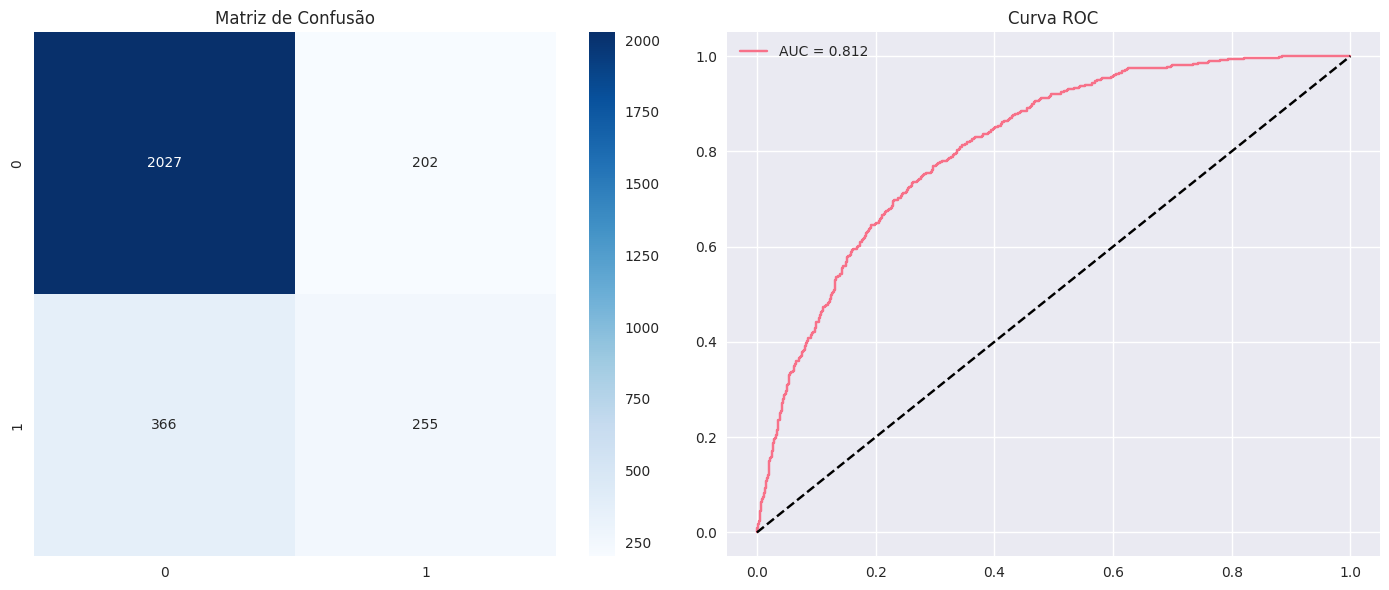

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)
    print("\nAVALIAÇÃO DO MODELO FINAL")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Average Precision: {ap_score:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Matriz de Confusão')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title('Curva ROC')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

evaluate_model(final_pipeline_optimized, X_test_selected, y_test)


# Fila de prioridade

In [ ]:
def generate_priority_queue(model, X_data, original_data_indices):
    probabilities = model.predict_proba(X_data)[:, 1]
    priority_df = pd.DataFrame({'client_id': original_data_indices, 'probability_score': probabilities})
    priority_df_sorted = priority_df.sort_values(by='probability_score', ascending=False).reset_index(drop=True)
    return priority_df_sorted

priority_list = generate_priority_queue(final_pipeline_optimized, X_test_selected, X_test.index)
print("Top 15 clientes para contato prioritário:")
print(priority_list.head(15))

Top 15 clientes para contato prioritário:
    client_id  probability_score
0        3499           0.835261
1        5710           0.813495
2        6661           0.785360
3         812           0.778922
4       14242           0.763469
5       14724           0.760824
6        2840           0.760514
7        1933           0.753636
8        3817           0.752999
9         379           0.752605
10       3726           0.747965
11       3058           0.747507
12       4794           0.743287
13       2564           0.737309
14       3064           0.729172


# Feature Importance (por modelo)

In [ ]:
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Cannot get feature importance for {model_name}. Skipping.")
        return
        
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20)) # Plot top 20
    plt.title(f'Feature Importance for {model_name}')
    plt.tight_layout()
    plt.show()


--- Analyzing: xgboost ---


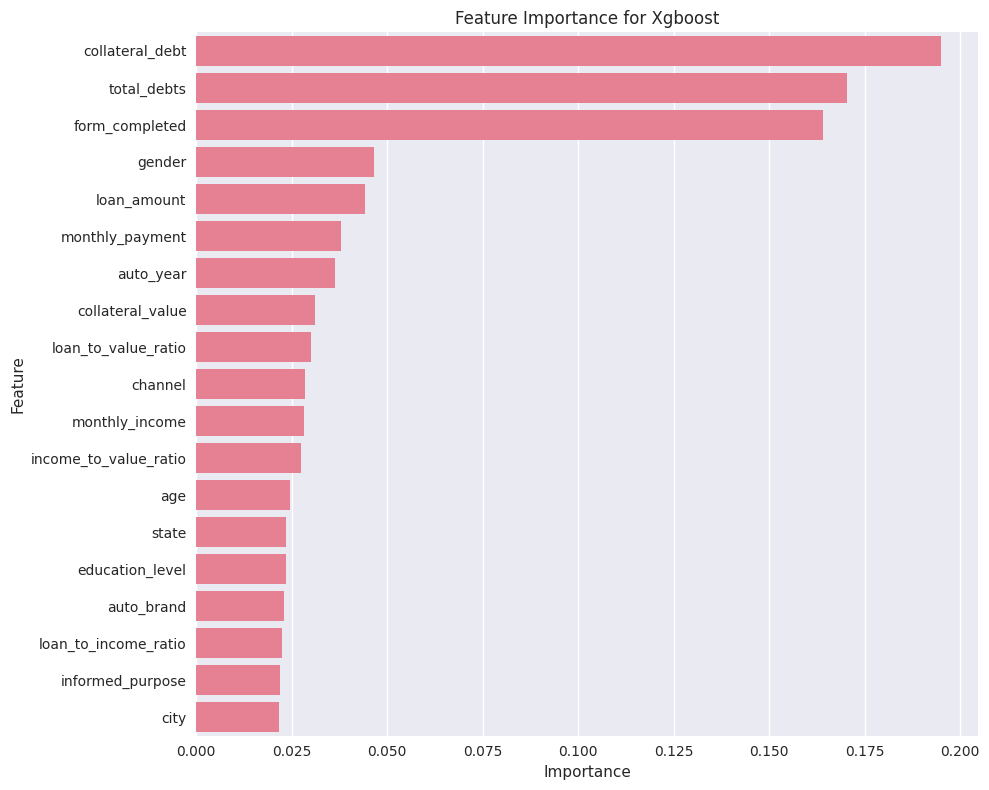


--- Analyzing: lightgbm ---


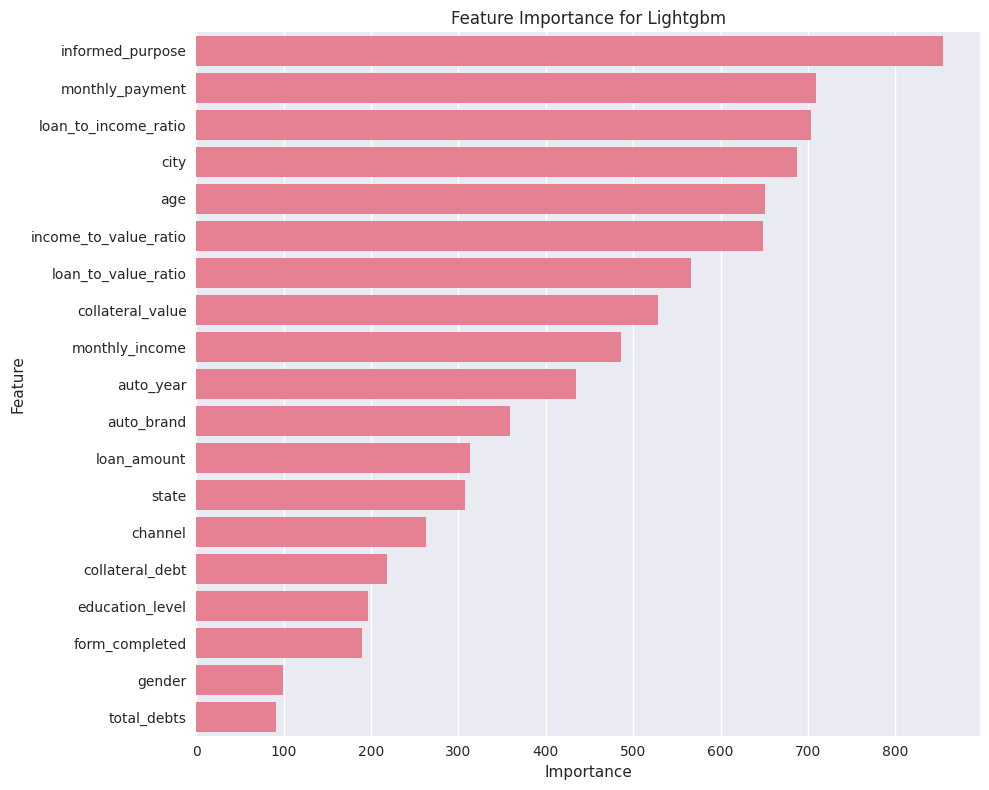


--- Analyzing: random_forest ---


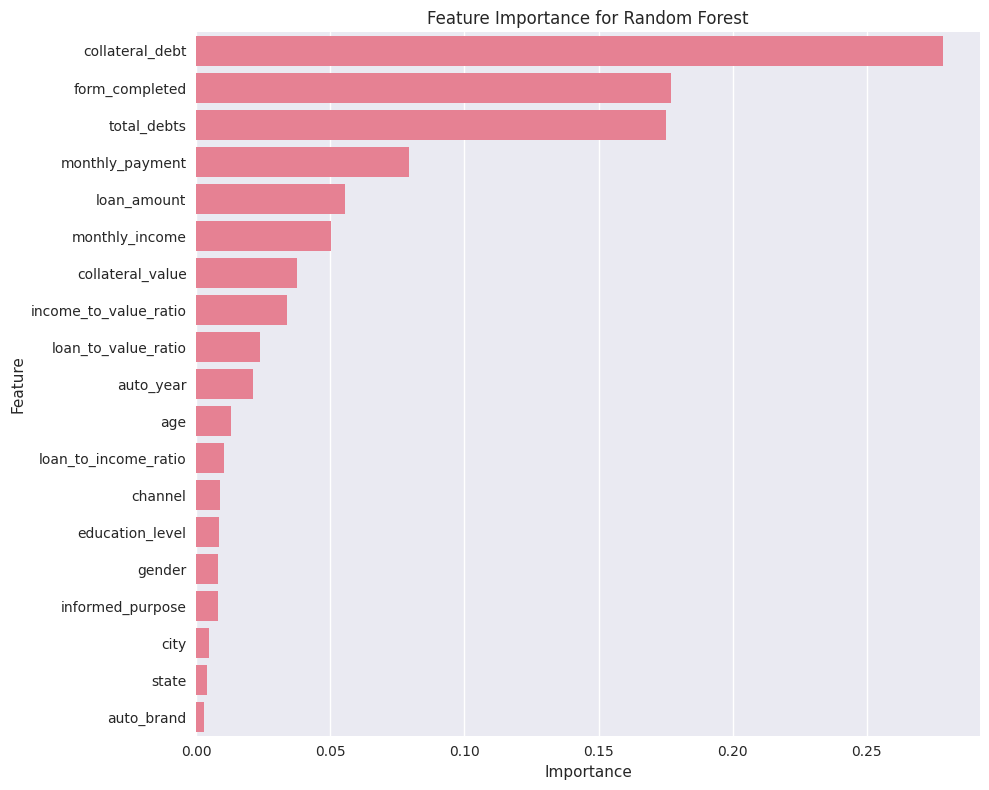


--- Analyzing: logistic ---


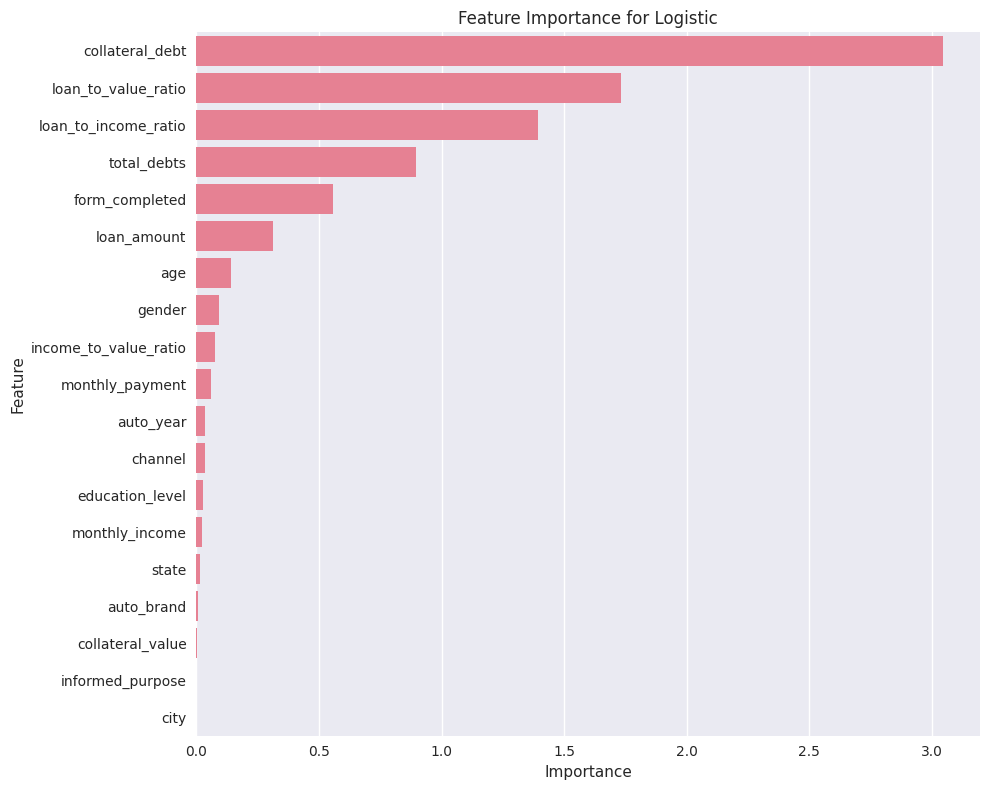


--- Analyzing: mlp ---
Cannot get feature importance for Mlp. Skipping.


In [ ]:
feature_names = selected_feature_names 
trained_estimators = final_pipeline_optimized.named_steps['classifier'].estimators_
estimator_names = [est[0] for est in final_ensemble.estimators]
for name, model in zip(estimator_names, trained_estimators):
    print(f"\n--- Analyzing: {name} ---")
    plot_feature_importance(model, feature_names, name.replace('_', ' ').title())

# Benchmark

=== COMPARAÇÃO COM BENCHMARKS (AUC Score) ===
Modelo ML: 0.8125
Aleatório: 0.5093
Prioridade Renda: 0.6384
Prioridade Valor Empréstimo: 0.3674
Prioridade LTV: 0.3990


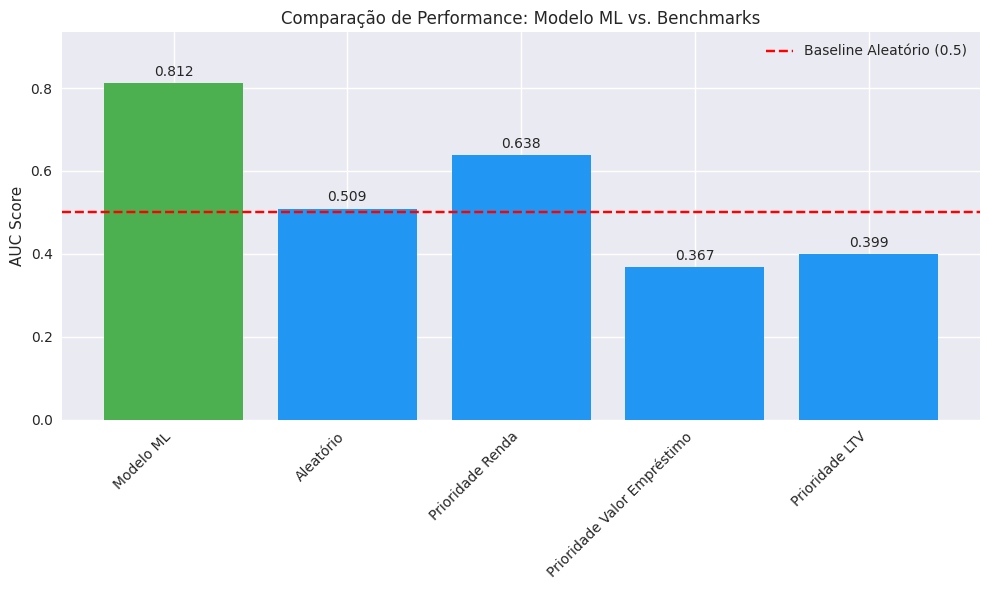

In [ ]:
y_pred_proba = final_pipeline_optimized.predict_proba(X_test_selected)[:, 1]
ml_model_auc = roc_auc_score(y_test, y_pred_proba)

def benchmark_comparison(X_test_data, y_test_data, ml_auc_score):
    
    random_probs = np.random.random(len(y_test_data))
    auc_random = roc_auc_score(y_test_data, random_probs)
    income_priority = X_test_data['monthly_income'].values
    auc_income = roc_auc_score(y_test_data, income_priority)
    loan_priority = -X_test_data['loan_amount'].values
    auc_loan = roc_auc_score(y_test_data, loan_priority)
    ltv_priority = -X_test_data['loan_to_value_ratio'].values
    auc_ltv = roc_auc_score(y_test_data, ltv_priority)
    
    benchmarks = {
        'Modelo ML': ml_auc_score,
        'Aleatório': auc_random,
        'Prioridade Renda': auc_income,
        'Prioridade Valor Empréstimo': auc_loan,
        'Prioridade LTV': auc_ltv
    }
    
    print("=== COMPARAÇÃO COM BENCHMARKS (AUC Score) ===")
    for method, score in benchmarks.items():
        print(f"{method}: {score:.4f}")
    
    plt.figure(figsize=(10, 6))
    methods = list(benchmarks.keys())
    scores = list(benchmarks.values())
    colors = ['#4CAF50' if x == 'Modelo ML' else '#2196F3' for x in methods]
    bars = plt.bar(methods, scores, color=colors)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Baseline Aleatório (0.5)')
    plt.ylabel('AUC Score')
    plt.title('Comparação de Performance: Modelo ML vs. Benchmarks')
    plt.xticks(rotation=45, ha="right")
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')
    
    plt.ylim(0, max(scores) * 1.15) 
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return benchmarks

benchmarks = benchmark_comparison(X_test, y_test, ml_model_auc)

In [ ]:
import pickle

filename = '../models/modelo_ensemble.pkl'

with open(filename, 'wb') as file:
    pickle.dump(final_pipeline_optimized, file)

print(f"\nModelo salvo com sucesso no arquivo: {filename}")


Modelo salvo com sucesso no arquivo: ../models/modelo_ensemble.pkl
